<a href="https://colab.research.google.com/github/ecuadrafoy/PracticalMachineLearning/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework RNNs
1. Download and explore data
2. Preproceess data if needed
3. Create a dataset with group of inputs of some size (between 10 and 50) - Similar to this [example](https://colab.research.google.com/drive/1tj0DRWxVvRC7_b7ubQ46zJo4ZuxT4jbW?authuser=1)
4. Split the data into train and test
5. Use 3 different RNN type

In [ ]:
!wget https://storage.googleapis.com/nicksdemobucket/sunspots.csv

# OR

!wget https://storage.googleapis.com/nicksdemobucket/temperatures.csv

# OR MNIST

--2020-07-03 18:49:35--  https://storage.googleapis.com/nicksdemobucket/sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45039 (44K) [application/octet-stream]
Saving to: ‘sunspots.csv.1’

sunspots.csv.1      100%[===================>]  43.98K  --.-KB/s    in 0s      

2020-07-03 18:49:35 (120 MB/s) - ‘sunspots.csv.1’ saved [45039/45039]

--2020-07-03 18:49:36--  https://storage.googleapis.com/nicksdemobucket/temperatures.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.203.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/csv]
Saving to: ‘temperatures.csv.1’

temperatures.csv.1  

## Exploring Sunspots Time Series

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LSTM, Input, Flatten, Conv1D, GRU, TimeDistributed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
df = pd.read_csv('sunspots.csv')


df.Month = pd.to_datetime(df.Month)
df.index = df.Month
df.sort_index(axis=0, inplace=True)
df.head()


,Month,Sunspots
Month,,
1749-01-01,1749-01-01,58.0
1749-02-01,1749-02-01,62.6
1749-03-01,1749-03-01,70.0
1749-04-01,1749-04-01,55.7
1749-05-01,1749-05-01,85.0


In [ ]:
df.tail()

,Month,Sunspots
Month,,
1983-08-01,1983-08-01,71.8
1983-09-01,1983-09-01,50.3
1983-10-01,1983-10-01,55.8
1983-11-01,1983-11-01,33.3
1983-12-01,1983-12-01,33.4


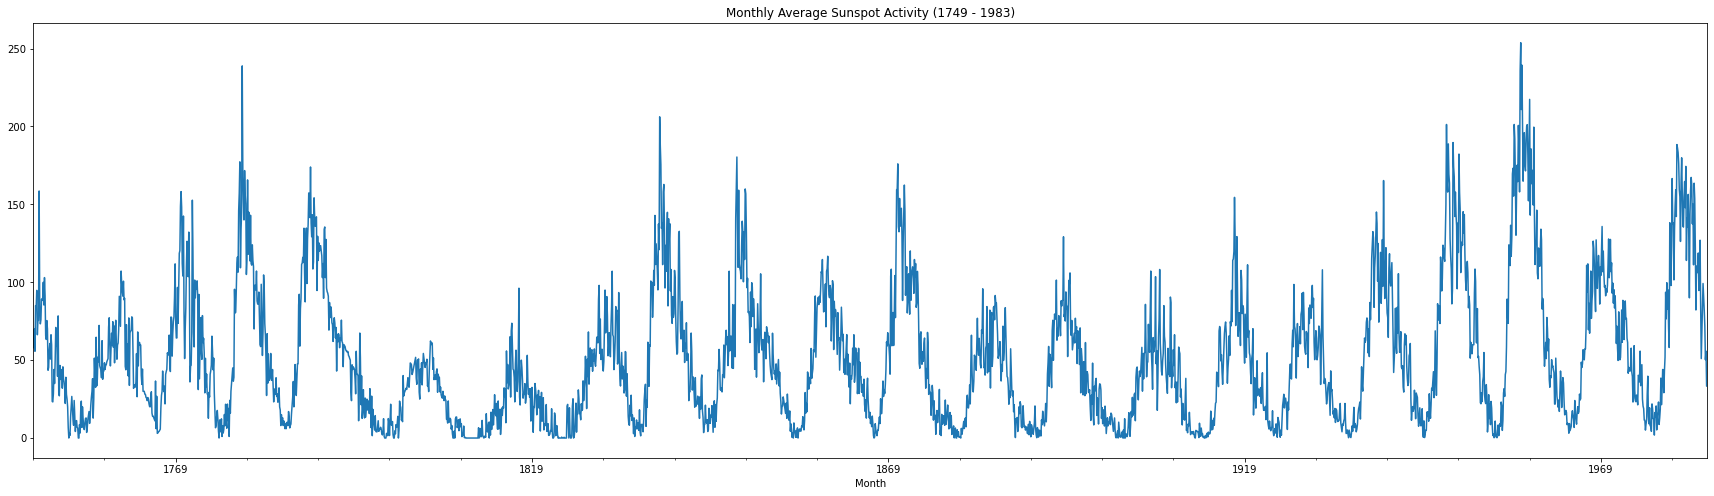

In [ ]:
df['Sunspots'].plot(figsize=(30,8), title = 'Monthly Average Sunspot Activity (1749 - 1983)')

## Cleaning Up the Data
Normalizing with MinMaxScaler

In [ ]:

split_date = pd.Timestamp('1950-01-01')

train = df.loc[:split_date,['Sunspots']]
test = df.loc[split_date:,['Sunspots']]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

Creating a sliding window

In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Month,
1749-01-01,0.242779
1749-02-01,0.262034
1749-03-01,0.293010
1749-04-01,0.233152
1749-05-01,0.355797


In [ ]:
for s in range(1, 50):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [ ]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [ ]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23,shift_24,shift_25,shift_26,shift_27,shift_28,shift_29,shift_30,shift_31,shift_32,shift_33,shift_34,shift_35,shift_36,shift_37,shift_38,shift_39,shift_40,shift_41,shift_42,shift_43,shift_44,shift_45,shift_46,shift_47,shift_48,shift_49
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1753-02-01,0.184177,0.167434,0.157388,0.195061,0.113437,0.122645,0.328171,0.165760,0.249895,0.248221,0.297195,0.209293,0.146505,0.184177,0.119297,0.097112,0.098368,0.250314,0.277522,0.212223,0.254081,0.236082,0.189619,0.182085,0.293010,0.315613,0.264964,0.275010,0.381750,0.431143,0.357472,0.418585,0.376727,0.369611,0.373378,0.317706,0.306823,0.356635,0.663876,0.316032,0.317706,0.277522,0.396819,0.349519,0.355797,0.233152,0.293010,0.262034,0.242779
1753-03-01,0.133947,0.184177,0.167434,0.157388,0.195061,0.113437,0.122645,0.328171,0.165760,0.249895,0.248221,0.297195,0.209293,0.146505,0.184177,0.119297,0.097112,0.098368,0.250314,0.277522,0.212223,0.254081,0.236082,0.189619,0.182085,0.293010,0.315613,0.264964,0.275010,0.381750,0.431143,0.357472,0.418585,0.376727,0.369611,0.373378,0.317706,0.306823,0.356635,0.663876,0.316032,0.317706,0.277522,0.396819,0.349519,0.355797,0.233152,0.293010,0.262034
1753-04-01,0.191293,0.133947,0.184177,0.167434,0.157388,0.195061,0.113437,0.122645,0.328171,0.165760,0.249895,0.248221,0.297195,0.209293,0.146505,0.184177,0.119297,0.097112,0.098368,0.250314,0.277522,0.212223,0.254081,0.236082,0.189619,0.182085,0.293010,0.315613,0.264964,0.275010,0.381750,0.431143,0.357472,0.418585,0.376727,0.369611,0.373378,0.317706,0.306823,0.356635,0.663876,0.316032,0.317706,0.277522,0.396819,0.349519,0.355797,0.233152,0.293010
1753-05-01,0.159062,0.191293,0.133947,0.184177,0.167434,0.157388,0.195061,0.113437,0.122645,0.328171,0.165760,0.249895,0.248221,0.297195,0.209293,0.146505,0.184177,0.119297,0.097112,0.098368,0.250314,0.277522,0.212223,0.254081,0.236082,0.189619,0.182085,0.293010,0.315613,0.264964,0.275010,0.381750,0.431143,0.357472,0.418585,0.376727,0.369611,0.373378,0.317706,0.306823,0.356635,0.663876,0.316032,0.317706,0.277522,0.396819,0.349519,0.355797,0.233152
1753-06-01,0.150691,0.159062,0.191293,0.133947,0.184177,0.167434,0.157388,0.195061,0.113437,0.122645,0.328171,0.165760,0.249895,0.248221,0.297195,0.209293,0.146505,0.184177,0.119297,0.097112,0.098368,0.250314,0.277522,0.212223,0.254081,0.236082,0.189619,0.182085,0.293010,0.315613,0.264964,0.275010,0.381750,0.431143,0.357472,0.418585,0.376727,0.369611,0.373378,0.317706,0.306823,0.356635,0.663876,0.316032,0.317706,0.277522,0.396819,0.349519,0.355797


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2364, 49)
(359, 49)
(2364, 1)
(359, 1)


In [ ]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 49, 1)
X_test_t = X_test.reshape(X_test.shape[0], 49, 1)

In [ ]:
X_train_t.shape

(2364, 49, 1)

In [ ]:
def plot_series(x, y, color='r'):
  plt.plot(x.reshape(-1), 'o-')
  plt.scatter(51, y, c=color)
  plt.grid(True)

## Using multilayer perceprtrons


*   The current model fits pretty well with our test set... maybe a little too well. Almost like it's overfitting
*   In fact looking at the bottom graph, the expected red dot doesnt match with the gree one.



In [ ]:
K.clear_session()
visible = Input(shape=(49,1))
flat = Flatten()(visible)
h1 = Dense(10, activation='relu')(flat)
output = Dense(1)(h1)

m1 = Model(inputs=visible, outputs = output)

In [ ]:
m1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 49)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                500       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 511
Trainable params: 511
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
m1.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
his1 = m1.fit(X_train_t, y_train, epochs=600, validation_data = (X_test_t, y_test),callbacks = [stop], batch_size=16, verbose=0)

In [ ]:
m1.evaluate(X_test_t, y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.0068 - mae: 0.0626


[0.00683373911306262, 0.06257612258195877]

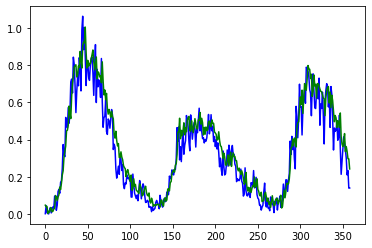

In [ ]:
y_pred = m1.predict(X_test_t)
plt.plot(y_test, 'b')
plt.plot(y_pred, 'g')

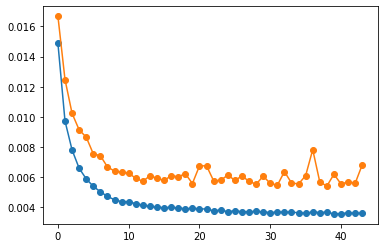

In [ ]:
plt.plot(his1.history['loss'], 'o-')
plt.plot(his1.history['val_loss'], 'o-')

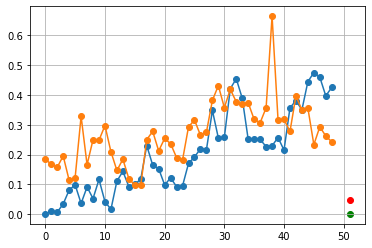

In [ ]:
y_pred = m1.predict(X_test_t)
plot_series(X_test_t[0], y_test[0], color='g')
plot_series(X_train_t[0], y_pred[0], color='r')
plt.show()

## Creating a simple LTSM Network


*   The model suffers less from overfitting as seen when superimposing them on each other
*   However it still suffers from bad prediction accuracy



In [ ]:
K.clear_session()
visible = Input(shape=(49,1))
h1 = LSTM(4)(visible)
output = Dense(1)(h1)

m2 = Model(inputs=visible, outputs = output)


In [ ]:
m2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
m2.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
his2 = m2.fit(X_train_t, y_train, epochs=600, validation_data = (X_test_t, y_test), callbacks = [stop], batch_size=16, verbose=0)

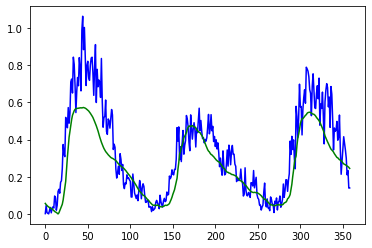

In [ ]:
y_pred = m2.predict(X_test_t)
plt.plot(y_test, 'b')
plt.plot(y_pred, 'g')

In [ ]:
 m2.evaluate(X_test_t, y_test)

12/12 [==============================] - 0s 3ms/step - loss: 0.0183 - mae: 0.0993


[0.018337219953536987, 0.09932579845190048]

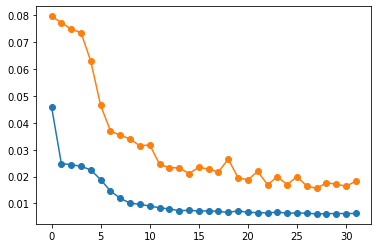

In [ ]:
plt.plot(his2.history['loss'], 'o-')
plt.plot(his2.history['val_loss'], 'o-')

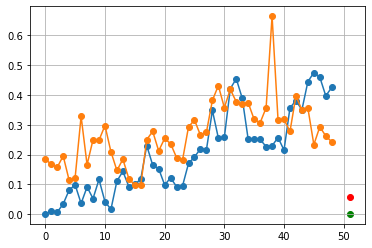

In [ ]:
y_pred = m2.predict(X_test_t)
plot_series(X_test_t[0], y_test[0], color='g')
plot_series(X_train_t[0], y_pred[0], color='r')
plt.show()

## Using 1D Convolutions

In [ ]:
K.clear_session()
visible = Input(shape=(None,1))
h1 = Conv1D(64, kernel_size=5, strides=1, padding='valid', activation='relu')(visible)
h2 = LSTM(64, return_sequences=True)(h1)
h3 = LSTM(64, return_sequences=True)(h2)
h4 = TimeDistributed(Dense(32, activation='relu'))(h3)
output = Dense(1)(h4)

m3 = Model(inputs=visible, outputs = output)

In [ ]:
m3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
Total params: 68,545
Trainable params: 68,545
Non-trainable params: 0
_________________________________________________________

In [ ]:
stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
m3.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
his3 = m3.fit(X_train_t, y_train, epochs=600, validation_data = (X_test_t, y_test), callbacks = [stop], batch_size=16, verbose=0)

ValueError: ignored

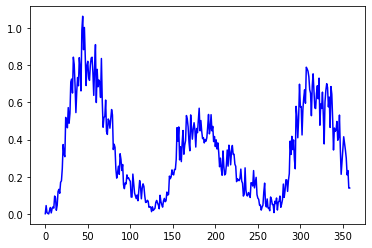

In [ ]:
y_pred = m3.predict(X_test_t)
plt.plot(y_test, 'b')
plt.plot(y_pred, 'g')

In [ ]:
 m3.evaluate(X_test_t, y_test)

12/12 [==============================] - 0s 13ms/step - loss: 0.0097 - mae: 0.0707


[0.009704776108264923, 0.07065566629171371]

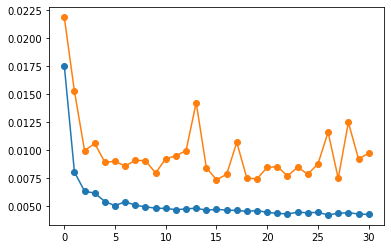

In [ ]:
plt.plot(his3.history['loss'], 'o-')
plt.plot(his3.history['val_loss'], 'o-')